In [256]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

%matplotlib inline

We define a function that takes a set of features per time frame and stack the mean so that the data becomes 1-Dimension.

In [2]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

In [3]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    print(num_classes)
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(fbeta_score(y_test, pred, beta= 1.0,average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

We import the binary files containing the original features (MFCCs, and Mel-Spectrogram) in 2D form, as well as the labels corresponding to each feature set.

In [225]:
#mel

f = open('IEMOCAP_Data/Data_10_sec/X_train_mel', 'rb')
X_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mel', 'rb')
X_test_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mel', 'rb')
y_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mel', 'rb')
y_test_mel = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_10_sec/X_train_mfcc', 'rb')
X_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mfcc', 'rb')
X_test_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mfcc', 'rb')
y_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mfcc', 'rb')
y_test_mfcc = joblib.load(f)
f.close()

## Find the indices of clipped audio (test)

In [226]:
X_test_mfcc.shape

(900, 40, 313)

In [227]:
clipped_indices = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_test_mel[i][j][k] != 0):
                clipped_indices.append(i)

len(clipped_indices)

1600

In [228]:
x_clipped =np.array(clipped_indices)
x_clipped =np.unique(x_clipped)

x_clipped

array([  5,  32,  37,  48,  69,  77,  80,  86, 107, 112, 116, 141, 145,
       154, 168, 172, 204, 210, 231, 236, 330, 351, 372, 417, 419, 464,
       482, 505, 587, 636, 693, 720, 733, 743, 756, 800, 811, 842, 852,
       897])

In [229]:
x_unclipped = []
for i in range(len(X_test_mel)):
    if i not in x_clipped:
        x_unclipped.append(i)
x_unclipped = np.array(x_unclipped)
#x_unclipped

In [230]:
len(x_unclipped)

860

32 + 40 = 72

## Examine clipped audio in train set

In [231]:
clipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                clipped_indices_train.append(i)

x_clipped_t =np.array(clipped_indices_train)
x_clipped_t =np.unique(x_clipped_t)

len(x_clipped_t)

32

In [232]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_clipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_clipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)

40

In [233]:
from collections import Counter
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({2: 10, 1: 9, 0: 8, 4: 7, 5: 6})


In [234]:
print("Train count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(train_labels.count(0),train_labels.count(1),train_labels.count(2),train_labels.count(3),train_labels.count(4),train_labels.count(5)))

Train count:
Anger: 2
Happy: 3
Sad: 12
Fear: 0
Surprise: 6
Neutral: 9



In [235]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 8
Happy: 9
Sad: 10
Fear: 0
Surprise: 7
Neutral: 6



In [236]:
dic_true_val = {}
dic_true_val['ang'] = test_labels.count(0)
dic_true_val['hap'] = test_labels.count(1)
dic_true_val['sad'] = test_labels.count(2)
dic_true_val['fea'] = test_labels.count(3)
dic_true_val['sur'] = test_labels.count(4)
dic_true_val['neu'] = test_labels.count(5)

## Unclipped audio

In [243]:
unclipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                unclipped_indices_train.append(i)

x_unclipped_t =np.array(unclipped_indices_train)
x_unclipped_t =np.unique(x_unclipped_t)

len(x_unclipped_t)

32

In [244]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_unclipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_unclipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)

860

In [245]:
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({3: 158, 4: 158, 5: 144, 1: 144, 2: 134, 0: 122})


In [246]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 122
Happy: 144
Sad: 134
Fear: 158
Surprise: 158
Neutral: 144



In [247]:
dic_true_val_unclipped = {}
dic_true_val_unclipped['ang'] = test_labels.count(0)
dic_true_val_unclipped['hap'] = test_labels.count(1)
dic_true_val_unclipped['sad'] = test_labels.count(2)
dic_true_val_unclipped['fea'] = test_labels.count(3)
dic_true_val_unclipped['sur'] = test_labels.count(4)
dic_true_val_unclipped['neu'] = test_labels.count(5)

### Converting to 1D Data

We convert the 2D features to 1D data.

In [5]:
X_train_mel_1d = []
X_test_mel_1d = []
X_train_mfcc_1d = []
X_test_mfcc_1d = []

In [6]:
for i in range(len(X_train_mel)):
    X_train_mel_1d.append(feature_to_1d(X_train_mel[i]))
for i in range(len(X_test_mel)):
    X_test_mel_1d.append(feature_to_1d(X_test_mel[i]))
for i in range(len(X_train_mfcc)):
    X_train_mfcc_1d.append(feature_to_1d(X_train_mfcc[i]))
for i in range(len(X_test_mfcc)):
    X_test_mfcc_1d.append(feature_to_1d(X_test_mfcc[i]))

In [7]:
X_train_mel = np.array(X_train_mel_1d)
X_test_mel = np.array(X_test_mel_1d)
X_train_mfcc = np.array(X_train_mfcc_1d)
X_test_mfcc = np.array(X_test_mfcc_1d)

In [8]:
X_train_mel.shape

(2100, 128)

In [9]:
X_train_mfcc.shape

(2100, 40)

Split data into train and test set per feature.

### Transform the y data 

We transform the y data containing the labels into onehot-encoded form so that the models can classify the categorical accuracy and loss.

In [10]:
y_onehot_train_mel = y_train_mel
y_onehot_test_mel = y_test_mel

y_onehot_train_mfcc = y_train_mfcc
y_onehot_test_mfcc = y_test_mfcc

In [11]:
y_onehot_train_mel = pd.get_dummies(y_onehot_train_mel)
y_onehot_test_mel = pd.get_dummies(y_onehot_test_mel)

y_onehot_train_mfcc = pd.get_dummies(y_onehot_train_mfcc)
y_onehot_test_mfcc = pd.get_dummies(y_onehot_test_mfcc)

In [12]:
y_onehot_train_mel = np.asarray(y_onehot_train_mel).astype('int8')
y_onehot_test_mel  = np.asarray(y_onehot_test_mel).astype('int8')

y_onehot_train_mfcc = np.asarray(y_onehot_train_mfcc).astype('int8')
y_onehot_test_mfcc  = np.asarray(y_onehot_test_mfcc).astype('int8')

Import libraries needed for defining the models.

In [13]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

Segmentation Models: using `tf.keras` framework.


In [14]:
X_train_mfcc.shape

(2100, 40)

Expand the dimensions for the training and testing data so that it can be used for the neural networks.

In [15]:
X_traincnn_mfcc = np.expand_dims(X_train_mfcc, axis = 2)
X_testcnn_mfcc = np.expand_dims(X_test_mfcc, axis = 2)
X_traincnn_mel = np.expand_dims(X_train_mel, axis = 2)
X_testcnn_mel = np.expand_dims(X_test_mel, axis = 2)

#### We define some functions for training and testing

In [16]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [248]:
def print_index(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_index = [] #indices of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_index.append(i)
            
    return correct_instances_index
def print_labels(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_label = [] #labels of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_label.append(y_pred[i])
            
    return correct_instances_label

In [249]:
def count_label(x):
    ang = 0
    hap = 0
    sad = 0
    fea = 0
    sur = 0
    neu = 0
    
    dic = {}
    #my_dict['name']='Nick'
    for i in range(len(x)):
        if(x[i]==0):
            ang += 1
        elif(x[i]==1):
            hap += 1
        elif(x[i]==2):
            sad += 1
        elif(x[i]==3):
            fea += 1
        elif(x[i]==4):
            sur += 1
        elif(x[i]==5):
            neu += 1
    dic['ang'] = ang
    dic['hap'] = hap
    dic['sad'] = sad
    dic['fea'] = fea
    dic['sur'] = sur
    dic['neu'] = neu
    
    return dic

In [17]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

### TDNN

We define the Time Delay Neural Netowrk Model. The model is based on a TDNN model used for flood prediction presented on ESoWC 2019 (MATHIW - Machine Learning Techniques for High Impact Weather) by Kugler & Lehner (https://github.com/MATEHIW-project).

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MinMaxNorm, NonNeg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        
        model = Sequential()
        self.cfg = kwargs
        
        filters = self.cfg.get('filters')
        input_shape = self.cfg.get('input_shape')
        
        self.epoch = self.cfg.get('epochs')
        self.batch_size = self.cfg.get('batch_size')
        
        model.add(Conv1D(filters[0], 6,padding='same',input_shape=(input_shape,1)))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(5)))
        model.add(BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in filters[1:]:
            model.add(Conv1D(n, 6,padding='same',))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        #model.add(Flatten())
        model.add(GlobalMaxPooling1D())
        model.add(Dense(6, activation='softmax'))
        opt = tf.keras.optimizers.Adam(lr=0.005) 
        
        #opt2 = tf.keras.optimizers.SGD(lr=0.0005)
        model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['categorical_accuracy', f1_loss])
        self.model = model

        self.callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        #X = self.xscaler.transform(Xda.values)
        #y = self.model.predict(X).squeeze()
        #y = self.yscaler.inverse_transform(y)
        
        #y = add_time(y, Xda.time, name=name)
        return self.model.predict(Xda)

    def evaluate(self, X, y):
        return self.model.evaluate(X, y)
    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        
        #print(X_train.shape)
        #X_train = self.xscaler.fit_transform(X_train)
        #y_train = self.yscaler.fit_transform(
                        #y_train.reshape(-1, 6))
        
        #X_valid = self.xscaler.transform(X_valid)
        #y_valid = self.yscaler.transform(y_valid.reshape(-1, 6))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.epoch,
                              batch_size=self.batch_size, **kwargs)
    def predict_classes(X):
        return model.predict_classes(X)
    
    def summary(self):
        return self.model.summary()

### 10 - Second clips

#### MFCC

We use MFCC as input features.

In [57]:
X_train_mfcc_np = np.array(X_train_mfcc)
X_test_mfcc_np = np.array(X_test_mfcc)
y_train_mfcc_np = np.array(y_train_mfcc)
y_test_mfcc_np = np.array(y_test_mfcc)

In [58]:
print(X_train_mfcc_np.shape)
print(X_test_mfcc_np.shape)
print(y_onehot_train_mfcc.shape)
print(y_onehot_test_mfcc.shape)

(2100, 40)
(900, 40)
(2100, 6)
(900, 6)


In [59]:
X_train_mfcc_np.shape

(2100, 40)

In [187]:
config = dict(filters=(32, 64),  
                input_shape=40,
                dropout=0.25,
                epochs=60,
                batch_size=50)

m_2 = DenseNN(**config)

hist_2 = m_2.fit(X_traincnn_mfcc, y_onehot_train_mfcc, X_testcnn_mfcc, y_onehot_test_mfcc)

Epoch 1/60
42/42 [==============================] - 2s 15ms/step - loss: 3.0925 - categorical_accuracy: 0.2199 - f1_loss: 0.8222 - val_loss: 3.6199 - val_categorical_accuracy: 0.1589 - val_f1_loss: 0.8736
Epoch 2/60
42/42 [==============================] - 0s 10ms/step - loss: 1.7860 - categorical_accuracy: 0.2909 - f1_loss: 0.7653 - val_loss: 2.1337 - val_categorical_accuracy: 0.2533 - val_f1_loss: 0.8220
Epoch 3/60
42/42 [==============================] - 0s 9ms/step - loss: 1.5837 - categorical_accuracy: 0.3509 - f1_loss: 0.7297 - val_loss: 1.6439 - val_categorical_accuracy: 0.2789 - val_f1_loss: 0.7746
Epoch 4/60
42/42 [==============================] - 0s 8ms/step - loss: 1.4759 - categorical_accuracy: 0.4085 - f1_loss: 0.7001 - val_loss: 1.9154 - val_categorical_accuracy: 0.2422 - val_f1_loss: 0.8074
Epoch 5/60
42/42 [==============================] - 0s 10ms/step - loss: 1.4752 - categorical_accuracy: 0.3948 - f1_loss: 0.6974 - val_loss: 1.7838 - val_categorical_accuracy: 0.2356

In [188]:
m_2.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 40, 32)            224       
_________________________________________________________________
activation_54 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 8, 32)             128       
_________________________________________________________________
dropout_54 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 8, 64)             12352     
_________________________________________________________________
activation_55 (Activation)   (None, 8, 64)           

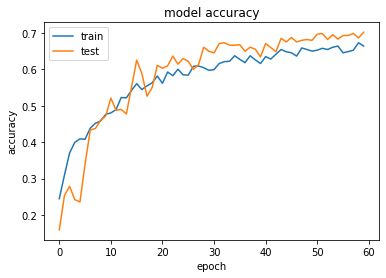

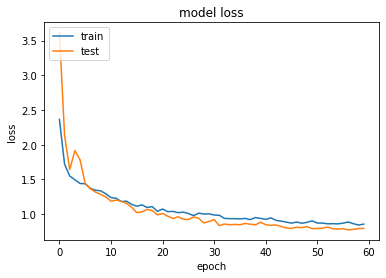

In [189]:
plt.plot(hist_2.history['categorical_accuracy'])
plt.plot(hist_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [252]:
loss, acc, f1_score = m_2.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 3ms/step - loss: 0.7951 - categorical_accuracy: 0.7022 - f1_loss: 0.4613
Restored model, accuracy: 70.22%


Confusion matrix, without normalization
[[ 97  19   2   0   2  10]
 [ 25  74  13   0  11  30]
 [ 15  16  51   1   3  58]
 [  0   0   0 158   0   0]
 [  0   0   0   0 157   8]
 [ 11  26  17   1   0  95]]


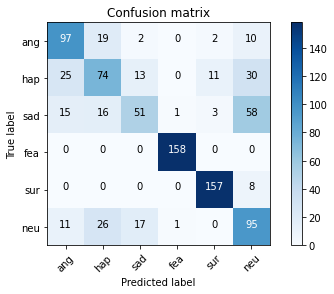

In [301]:
y_pred = m_2.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [302]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.66      0.75      0.70       130
         hap       0.55      0.48      0.51       153
         sad       0.61      0.35      0.45       144
         fea       0.99      1.00      0.99       158
         sur       0.91      0.95      0.93       165
         neu       0.47      0.63      0.54       150

    accuracy                           0.70       900
   macro avg       0.70      0.69      0.69       900
weighted avg       0.70      0.70      0.70       900



In [303]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

len(correct_indices)

632

In [304]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

In [305]:
dic_val_clipped = count_label(label_of_clipped_recognized)

dic_val_clipped

{'ang': 8, 'hap': 4, 'sad': 4, 'fea': 0, 'sur': 7, 'neu': 4}

<BarContainer object of 6 artists>

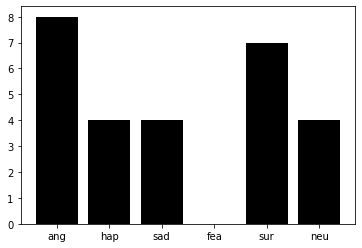

In [306]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [307]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 27
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.675

Anger: 8
Happiness: 4
Sadness: 4
Surpise: 7
Neutral: 4
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [308]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

len(indices_of_unclipped_recognized)

605

<BarContainer object of 6 artists>

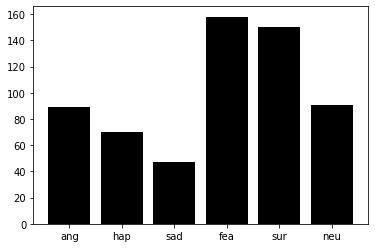

In [309]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [310]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 605
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.7034883720930233

Anger: 89
Happiness: 70
Sadness: 47
Surpise: 150
Neutral: 91
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



#### MEL

We use Mel-Spectrogram as input features.

In [192]:
X_train_mel_np = np.array(X_train_mel)
X_test_mel_np = np.array(X_test_mel)
y_train_mel_np = np.array(y_train_mel)
y_test_mel_np = np.array(y_test_mel)

In [218]:
config = dict(filters=(64, 128),  
                input_shape=128,
                dropout=0.25,
                epochs=80,
                batch_size=50)

m_mel_2 = DenseNN(**config)

hist_mel_2 = m_mel_2.fit(X_traincnn_mel, y_onehot_train_mel, X_testcnn_mel, y_onehot_test_mel)

Epoch 1/80
42/42 [==============================] - 2s 20ms/step - loss: 3.4137 - categorical_accuracy: 0.2539 - f1_loss: 0.8028 - val_loss: 3.1827 - val_categorical_accuracy: 0.3144 - val_f1_loss: 0.7283
Epoch 2/80
42/42 [==============================] - 1s 13ms/step - loss: 1.8800 - categorical_accuracy: 0.3463 - f1_loss: 0.7287 - val_loss: 2.0990 - val_categorical_accuracy: 0.3833 - val_f1_loss: 0.6984
Epoch 3/80
42/42 [==============================] - 1s 14ms/step - loss: 1.7266 - categorical_accuracy: 0.3824 - f1_loss: 0.7031 - val_loss: 1.5157 - val_categorical_accuracy: 0.3878 - val_f1_loss: 0.6766
Epoch 4/80
42/42 [==============================] - 1s 14ms/step - loss: 1.5361 - categorical_accuracy: 0.4071 - f1_loss: 0.6910 - val_loss: 1.4176 - val_categorical_accuracy: 0.4244 - val_f1_loss: 0.6653
Epoch 5/80
42/42 [==============================] - 1s 13ms/step - loss: 1.5036 - categorical_accuracy: 0.4195 - f1_loss: 0.6835 - val_loss: 1.4008 - val_categorical_accuracy: 0.41

In [219]:
m_mel_2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 128, 64)           448       
_________________________________________________________________
activation_66 (Activation)   (None, 128, 64)           0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 25, 64)            0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 25, 64)            256       
_________________________________________________________________
dropout_66 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 25, 128)           49280     
_________________________________________________________________
activation_67 (Activation)   (None, 25, 128)         

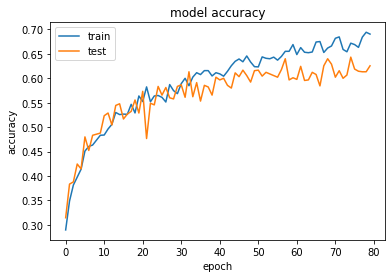

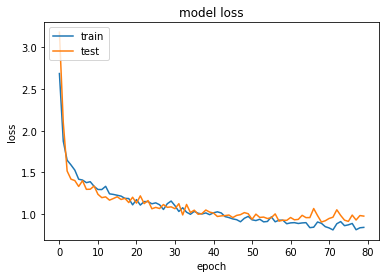

In [220]:
plt.plot(hist_mel_2.history['categorical_accuracy'])
plt.plot(hist_mel_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_mel_2.history['loss'])
plt.plot(hist_mel_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [268]:
loss, acc, f1_score = m_mel_2.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 6ms/step - loss: 0.9737 - categorical_accuracy: 0.6256 - f1_loss: 0.4761
Restored model, accuracy: 62.56%


Confusion matrix, without normalization
[[106  12   5   0   2   5]
 [ 60  45  12   0   9  27]
 [ 37  21  36   0   4  46]
 [  0   0   0 158   0   0]
 [  0   8   6   0 151   0]
 [ 27  23  27   1   5  67]]


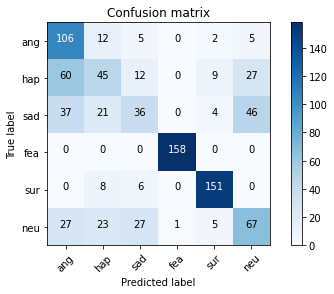

In [311]:
y_pred = m_mel_2.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [312]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.46      0.82      0.59       130
         hap       0.41      0.29      0.34       153
         sad       0.42      0.25      0.31       144
         fea       0.99      1.00      1.00       158
         sur       0.88      0.92      0.90       165
         neu       0.46      0.45      0.45       150

    accuracy                           0.63       900
   macro avg       0.61      0.62      0.60       900
weighted avg       0.62      0.63      0.61       900



In [313]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

len(correct_indices)

563

In [314]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

dic_val_clipped

{'ang': 8, 'hap': 1, 'sad': 4, 'fea': 0, 'sur': 7, 'neu': 4}

<BarContainer object of 6 artists>

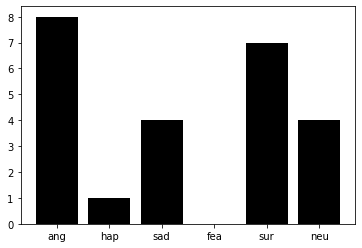

In [315]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [316]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 24
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.6

Anger: 8
Happiness: 1
Sadness: 4
Surpise: 7
Neutral: 4
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [317]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

len(indices_of_unclipped_recognized)

539

In [318]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

<BarContainer object of 6 artists>

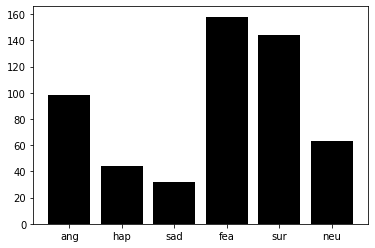

In [319]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [320]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 539
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6267441860465116

Anger: 98
Happiness: 44
Sadness: 32
Surpise: 144
Neutral: 63
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



## 29 - Second clips

In [71]:
#mel

f = open('IEMOCAP_Data/Data_30_sec/X_train_mel', 'rb')
X_train_mel_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mel', 'rb')
X_test_mel_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mel', 'rb')
y_train_mel_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mel', 'rb')
y_test_mel_30 = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_30_sec/X_train_mfcc', 'rb')
X_train_mfcc_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mfcc', 'rb')
X_test_mfcc_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mfcc', 'rb')
y_train_mfcc_30 = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mfcc', 'rb')
y_test_mfcc_30 = joblib.load(f)
f.close()

In [72]:
X_train_mel_1d_30 = []
X_test_mel_1d_30 = []
X_train_mfcc_1d_30 = []
X_test_mfcc_1d_30 = []

for i in range(len(X_train_mel_30)):
    X_train_mel_1d_30.append(feature_to_1d(X_train_mel_30[i]))
for i in range(len(X_test_mel_30)):
    X_test_mel_1d_30.append(feature_to_1d(X_test_mel_30[i]))
for i in range(len(X_train_mfcc_30)):
    X_train_mfcc_1d_30.append(feature_to_1d(X_train_mfcc_30[i]))
for i in range(len(X_test_mfcc_30)):
    X_test_mfcc_1d_30.append(feature_to_1d(X_test_mfcc_30[i]))
    
X_train_mel_30 = np.array(X_train_mel_1d_30)
X_test_mel_30 = np.array(X_test_mel_1d_30)
X_train_mfcc_30 = np.array(X_train_mfcc_1d_30)
X_test_mfcc_30 = np.array(X_test_mfcc_1d_30)    

### Transform y data

In [73]:
y_onehot_train_mel_30 = y_train_mel_30
y_onehot_test_mel_30 = y_test_mel_30

y_onehot_train_mfcc_30 = y_train_mfcc_30
y_onehot_test_mfcc_30 = y_test_mfcc_30

y_onehot_train_mel_30 = pd.get_dummies(y_onehot_train_mel_30)
y_onehot_test_mel_30 = pd.get_dummies(y_onehot_test_mel_30)

y_onehot_train_mfcc_30 = pd.get_dummies(y_onehot_train_mfcc_30)
y_onehot_test_mfcc_30 = pd.get_dummies(y_onehot_test_mfcc_30)

y_onehot_train_mel_30 = np.asarray(y_onehot_train_mel_30).astype('int8')
y_onehot_test_mel_30  = np.asarray(y_onehot_test_mel_30).astype('int8')

y_onehot_train_mfcc_30 = np.asarray(y_onehot_train_mfcc_30).astype('int8')
y_onehot_test_mfcc_30 = np.asarray(y_onehot_test_mfcc_30).astype('int8')

Expand the dimensions

In [74]:
X_traincnn_mfcc_30 = np.expand_dims(X_train_mfcc_30, axis = 2)
X_testcnn_mfcc_30 = np.expand_dims(X_test_mfcc_30, axis = 2)
X_traincnn_mel_30 = np.expand_dims(X_train_mel_30, axis = 2)
X_testcnn_mel_30 = np.expand_dims(X_test_mel_30, axis = 2)

### MFCC

In [198]:
config = dict(filters=(32, 64),  
                input_shape=40,
                dropout=0.25,
                epochs=60,
                batch_size=50)

m_2_30 = DenseNN(**config)

hist_2_30 = m_2_30.fit(X_traincnn_mfcc_30, y_onehot_train_mfcc_30, X_testcnn_mfcc_30, y_onehot_test_mfcc_30)

Epoch 1/60
42/42 [==============================] - 2s 16ms/step - loss: 2.7675 - categorical_accuracy: 0.2046 - f1_loss: 0.8209 - val_loss: 2.5175 - val_categorical_accuracy: 0.1911 - val_f1_loss: 0.8607
Epoch 2/60
42/42 [==============================] - 0s 9ms/step - loss: 1.7626 - categorical_accuracy: 0.2919 - f1_loss: 0.7718 - val_loss: 1.8521 - val_categorical_accuracy: 0.2200 - val_f1_loss: 0.8185
Epoch 3/60
42/42 [==============================] - 0s 10ms/step - loss: 1.6275 - categorical_accuracy: 0.3430 - f1_loss: 0.7447 - val_loss: 1.7054 - val_categorical_accuracy: 0.2700 - val_f1_loss: 0.8008
Epoch 4/60
42/42 [==============================] - 0s 9ms/step - loss: 1.5338 - categorical_accuracy: 0.3719 - f1_loss: 0.7233 - val_loss: 1.7059 - val_categorical_accuracy: 0.2100 - val_f1_loss: 0.7965
Epoch 5/60
42/42 [==============================] - 0s 9ms/step - loss: 1.4678 - categorical_accuracy: 0.4065 - f1_loss: 0.7002 - val_loss: 2.0755 - val_categorical_accuracy: 0.1956 

In [199]:
m_2_30.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 40, 32)            224       
_________________________________________________________________
activation_58 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 8, 32)             128       
_________________________________________________________________
dropout_58 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 8, 64)             12352     
_________________________________________________________________
activation_59 (Activation)   (None, 8, 64)           

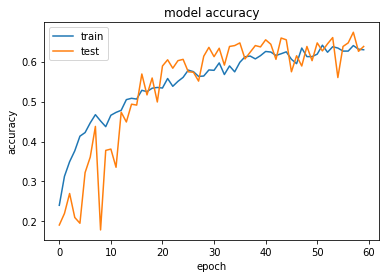

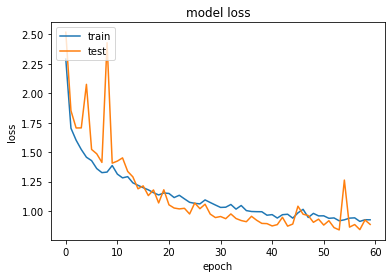

In [200]:
plt.plot(hist_2_30.history['categorical_accuracy'])
plt.plot(hist_2_30.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_2_30.history['loss'])
plt.plot(hist_2_30.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [279]:
loss, acc, f1_score = m_2_30.evaluate(X_testcnn_mfcc_30, y_onehot_test_mfcc_30)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 3ms/step - loss: 0.8872 - categorical_accuracy: 0.6378 - f1_loss: 0.5080
Restored model, accuracy: 63.78%


Confusion matrix, without normalization
[[ 72  31   9   0   4  14]
 [ 17  86  20   1   9  20]
 [ 13  20  66   3   1  41]
 [  0   0   0 158   0   0]
 [  0  10  10   5 126  14]
 [  8  36  36   1   3  66]]


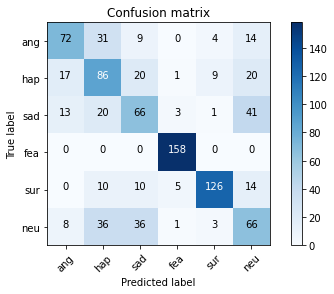

In [321]:
y_pred = m_2_30.predict(X_testcnn_mfcc_30)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc_30.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [322]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.65      0.55      0.60       130
         hap       0.47      0.56      0.51       153
         sad       0.47      0.46      0.46       144
         fea       0.94      1.00      0.97       158
         sur       0.88      0.76      0.82       165
         neu       0.43      0.44      0.43       150

    accuracy                           0.64       900
   macro avg       0.64      0.63      0.63       900
weighted avg       0.65      0.64      0.64       900



In [323]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

len(correct_indices)

574

In [324]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

dic_val_clipped

{'ang': 7, 'hap': 3, 'sad': 5, 'fea': 0, 'sur': 7, 'neu': 3}

<BarContainer object of 6 artists>

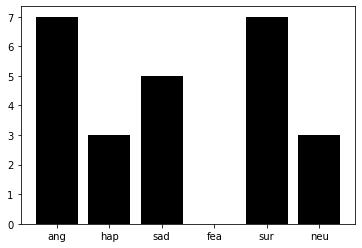

In [325]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [326]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 25
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.625

Anger: 7
Happiness: 3
Sadness: 5
Surpise: 7
Neutral: 3
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [327]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)
len(indices_of_unclipped_recognized)

549

In [328]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

<BarContainer object of 6 artists>

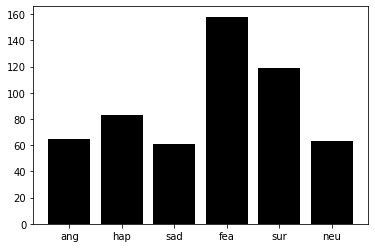

In [329]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [330]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 549
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6383720930232558

Anger: 65
Happiness: 83
Sadness: 61
Surpise: 119
Neutral: 63
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



## Mel

In [208]:
config = dict(filters=(64, 128),  
                input_shape=128,
                dropout=0.25,
                epochs=80,
                batch_size=50)

m_mel_2_30 = DenseNN(**config)

hist_mel_2_30 = m_mel_2_30.fit(X_traincnn_mel_30, y_onehot_train_mel_30, X_testcnn_mel_30, y_onehot_test_mel_30)

Epoch 1/80
42/42 [==============================] - 2s 21ms/step - loss: 3.1049 - categorical_accuracy: 0.2328 - f1_loss: 0.8087 - val_loss: 2.6634 - val_categorical_accuracy: 0.3278 - val_f1_loss: 0.7316
Epoch 2/80
42/42 [==============================] - 1s 15ms/step - loss: 1.7091 - categorical_accuracy: 0.3513 - f1_loss: 0.7277 - val_loss: 1.5717 - val_categorical_accuracy: 0.4533 - val_f1_loss: 0.6753
Epoch 3/80
42/42 [==============================] - 1s 15ms/step - loss: 1.7349 - categorical_accuracy: 0.3576 - f1_loss: 0.7235 - val_loss: 1.6205 - val_categorical_accuracy: 0.3900 - val_f1_loss: 0.6977
Epoch 4/80
42/42 [==============================] - 1s 15ms/step - loss: 1.6014 - categorical_accuracy: 0.4014 - f1_loss: 0.7069 - val_loss: 1.4651 - val_categorical_accuracy: 0.4211 - val_f1_loss: 0.6931
Epoch 5/80
42/42 [==============================] - 1s 20ms/step - loss: 1.5278 - categorical_accuracy: 0.3940 - f1_loss: 0.6949 - val_loss: 1.5267 - val_categorical_accuracy: 0.38

In [209]:
m_2_30.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 40, 32)            224       
_________________________________________________________________
activation_58 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 8, 32)             128       
_________________________________________________________________
dropout_58 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 8, 64)             12352     
_________________________________________________________________
activation_59 (Activation)   (None, 8, 64)           

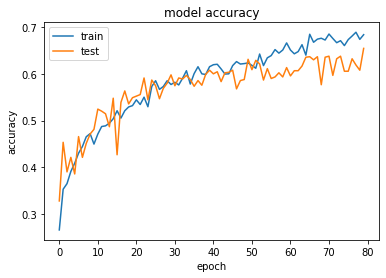

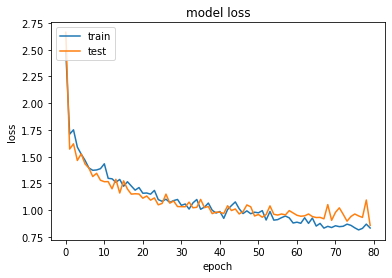

In [210]:
plt.plot(hist_mel_2_30.history['categorical_accuracy'])
plt.plot(hist_mel_2_30.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_mel_2_30.history['loss'])
plt.plot(hist_mel_2_30.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [290]:
loss, acc, f1_score = m_mel_2_30.evaluate(X_testcnn_mel_30, y_onehot_test_mel_30)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 5ms/step - loss: 0.8580 - categorical_accuracy: 0.6544 - f1_loss: 0.4661
Restored model, accuracy: 65.44%


Confusion matrix, without normalization
[[100  17  11   0   1   1]
 [ 44  56  28   0   5  20]
 [ 23  28  62   1   1  29]
 [  0   0   0 158   0   0]
 [  5   0   6   0 154   0]
 [ 25  23  41   1   1  59]]


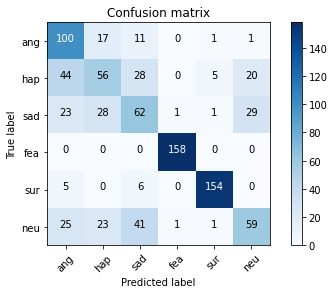

In [331]:
y_pred = m_mel_2_30.predict(X_testcnn_mel_30)
matrix = metrics.confusion_matrix(y_onehot_test_mel_30.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [332]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.51      0.77      0.61       130
         hap       0.45      0.37      0.40       153
         sad       0.42      0.43      0.42       144
         fea       0.99      1.00      0.99       158
         sur       0.95      0.93      0.94       165
         neu       0.54      0.39      0.46       150

    accuracy                           0.65       900
   macro avg       0.64      0.65      0.64       900
weighted avg       0.65      0.65      0.65       900



In [333]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

len(correct_indices)

589

In [334]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

dic_val_clipped


{'ang': 7, 'hap': 5, 'sad': 5, 'fea': 0, 'sur': 7, 'neu': 3}

<BarContainer object of 6 artists>

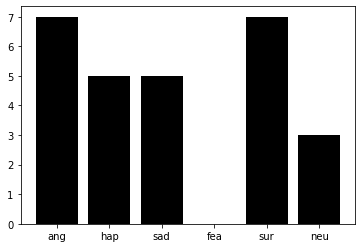

In [335]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [336]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 27
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.675

Anger: 7
Happiness: 5
Sadness: 5
Surpise: 7
Neutral: 3
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [337]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)
len(indices_of_unclipped_recognized)

562

In [338]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

<BarContainer object of 6 artists>

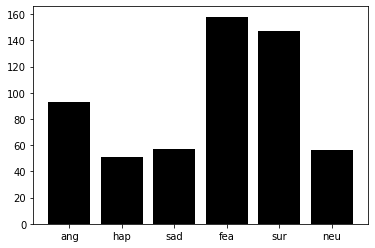

In [339]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [340]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 562
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6534883720930232

Anger: 93
Happiness: 51
Sadness: 57
Surpise: 147
Neutral: 56
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158

